In [1]:
# Imports for Analysis
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import hvplot.pandas

# Imports for API 
import requests
import json
from api_keys import geoapify_key
from api_keys import api_ninjas_key

In [2]:
# Import the csv file
file_path = './Resources/global_electricity_production_data.csv'
original_df = pd.read_csv(file_path)

# Create a column for the year
original_df['Year'] = original_df['date'].str.split('/').str[-1]

# Display the first 12 rows to show all of the different products
original_df.head(13)

,country_name,date,parameter,product,value,unit,Year
0,Australia,12/1/2023,Net Electricity Production,Electricity,22646.1901,GWh,2023
1,Australia,12/1/2023,Net Electricity Production,Total Combustible Fuels,13397.9356,GWh,2023
2,Australia,12/1/2023,Net Electricity Production,"Coal, Peat and Manufactured Gases",9768.5223,GWh,2023
3,Australia,12/1/2023,Net Electricity Production,Oil and Petroleum Products,289.5415,GWh,2023
4,Australia,12/1/2023,Net Electricity Production,Natural Gas,3091.9272,GWh,2023
5,Australia,12/1/2023,Net Electricity Production,Combustible Renewables,247.9446,GWh,2023
6,Australia,12/1/2023,Net Electricity Production,Hydro,1047.8540,GWh,2023
7,Australia,12/1/2023,Net Electricity Production,Wind,2719.2534,GWh,2023
8,Australia,12/1/2023,Net Electricity Production,Solar,5481.1471,GWh,2023
9,Australia,12/1/2023,Net Electricity Production,"Total Renewables (Hydro, Geo, Solar, Wind, Other)",9496.1991,GWh,2023


# How does the US compare to other countries in terms of electricity production?

In [3]:
# Filter the raw dataframe down to only total production of electricity
production_filter = (original_df['parameter'] == 'Net Electricity Production')&(original_df['product']=='Electricity')
production_df = original_df[production_filter]

# Display dataframe
production_df.head()

,country_name,date,parameter,product,value,unit,Year
0,Australia,12/1/2023,Net Electricity Production,Electricity,22646.1901,GWh,2023
13,Austria,12/1/2023,Net Electricity Production,Electricity,6783.2730,GWh,2023
31,Belgium,12/1/2023,Net Electricity Production,Electricity,6799.1069,GWh,2023
49,Canada,12/1/2023,Net Electricity Production,Electricity,55982.2209,GWh,2023
68,Chile,12/1/2023,Net Electricity Production,Electricity,7734.9912,GWh,2023


In [4]:
# Group the dataframe by country and sum the value
production_by_country = production_df.groupby(['country_name','Year'])['value'].sum()
production_by_country_df = production_by_country.reset_index()

# Disable scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display dataframe
production_by_country_df.head()

,country_name,Year,value
0,Argentina,2015,137590.83
1,Argentina,2016,139172.17
2,Argentina,2017,137915.23
3,Argentina,2018,139188.12
4,Argentina,2019,132462.31


In [5]:
# Filter down to the electricity production for 2023
production_by_country_2023_df = production_by_country_df[production_by_country_df['Year']=='2023']

# Drop unneeded year column
production_by_country_2023_df = production_by_country_2023_df.drop(columns='Year')

# Display first 5 rows in dataframe
production_by_country_2023_df.head()

,country_name,value
8,Argentina,130607.86
22,Australia,261570.59
36,Austria,67958.49
50,Belgium,78668.68
59,Brazil,690334.72


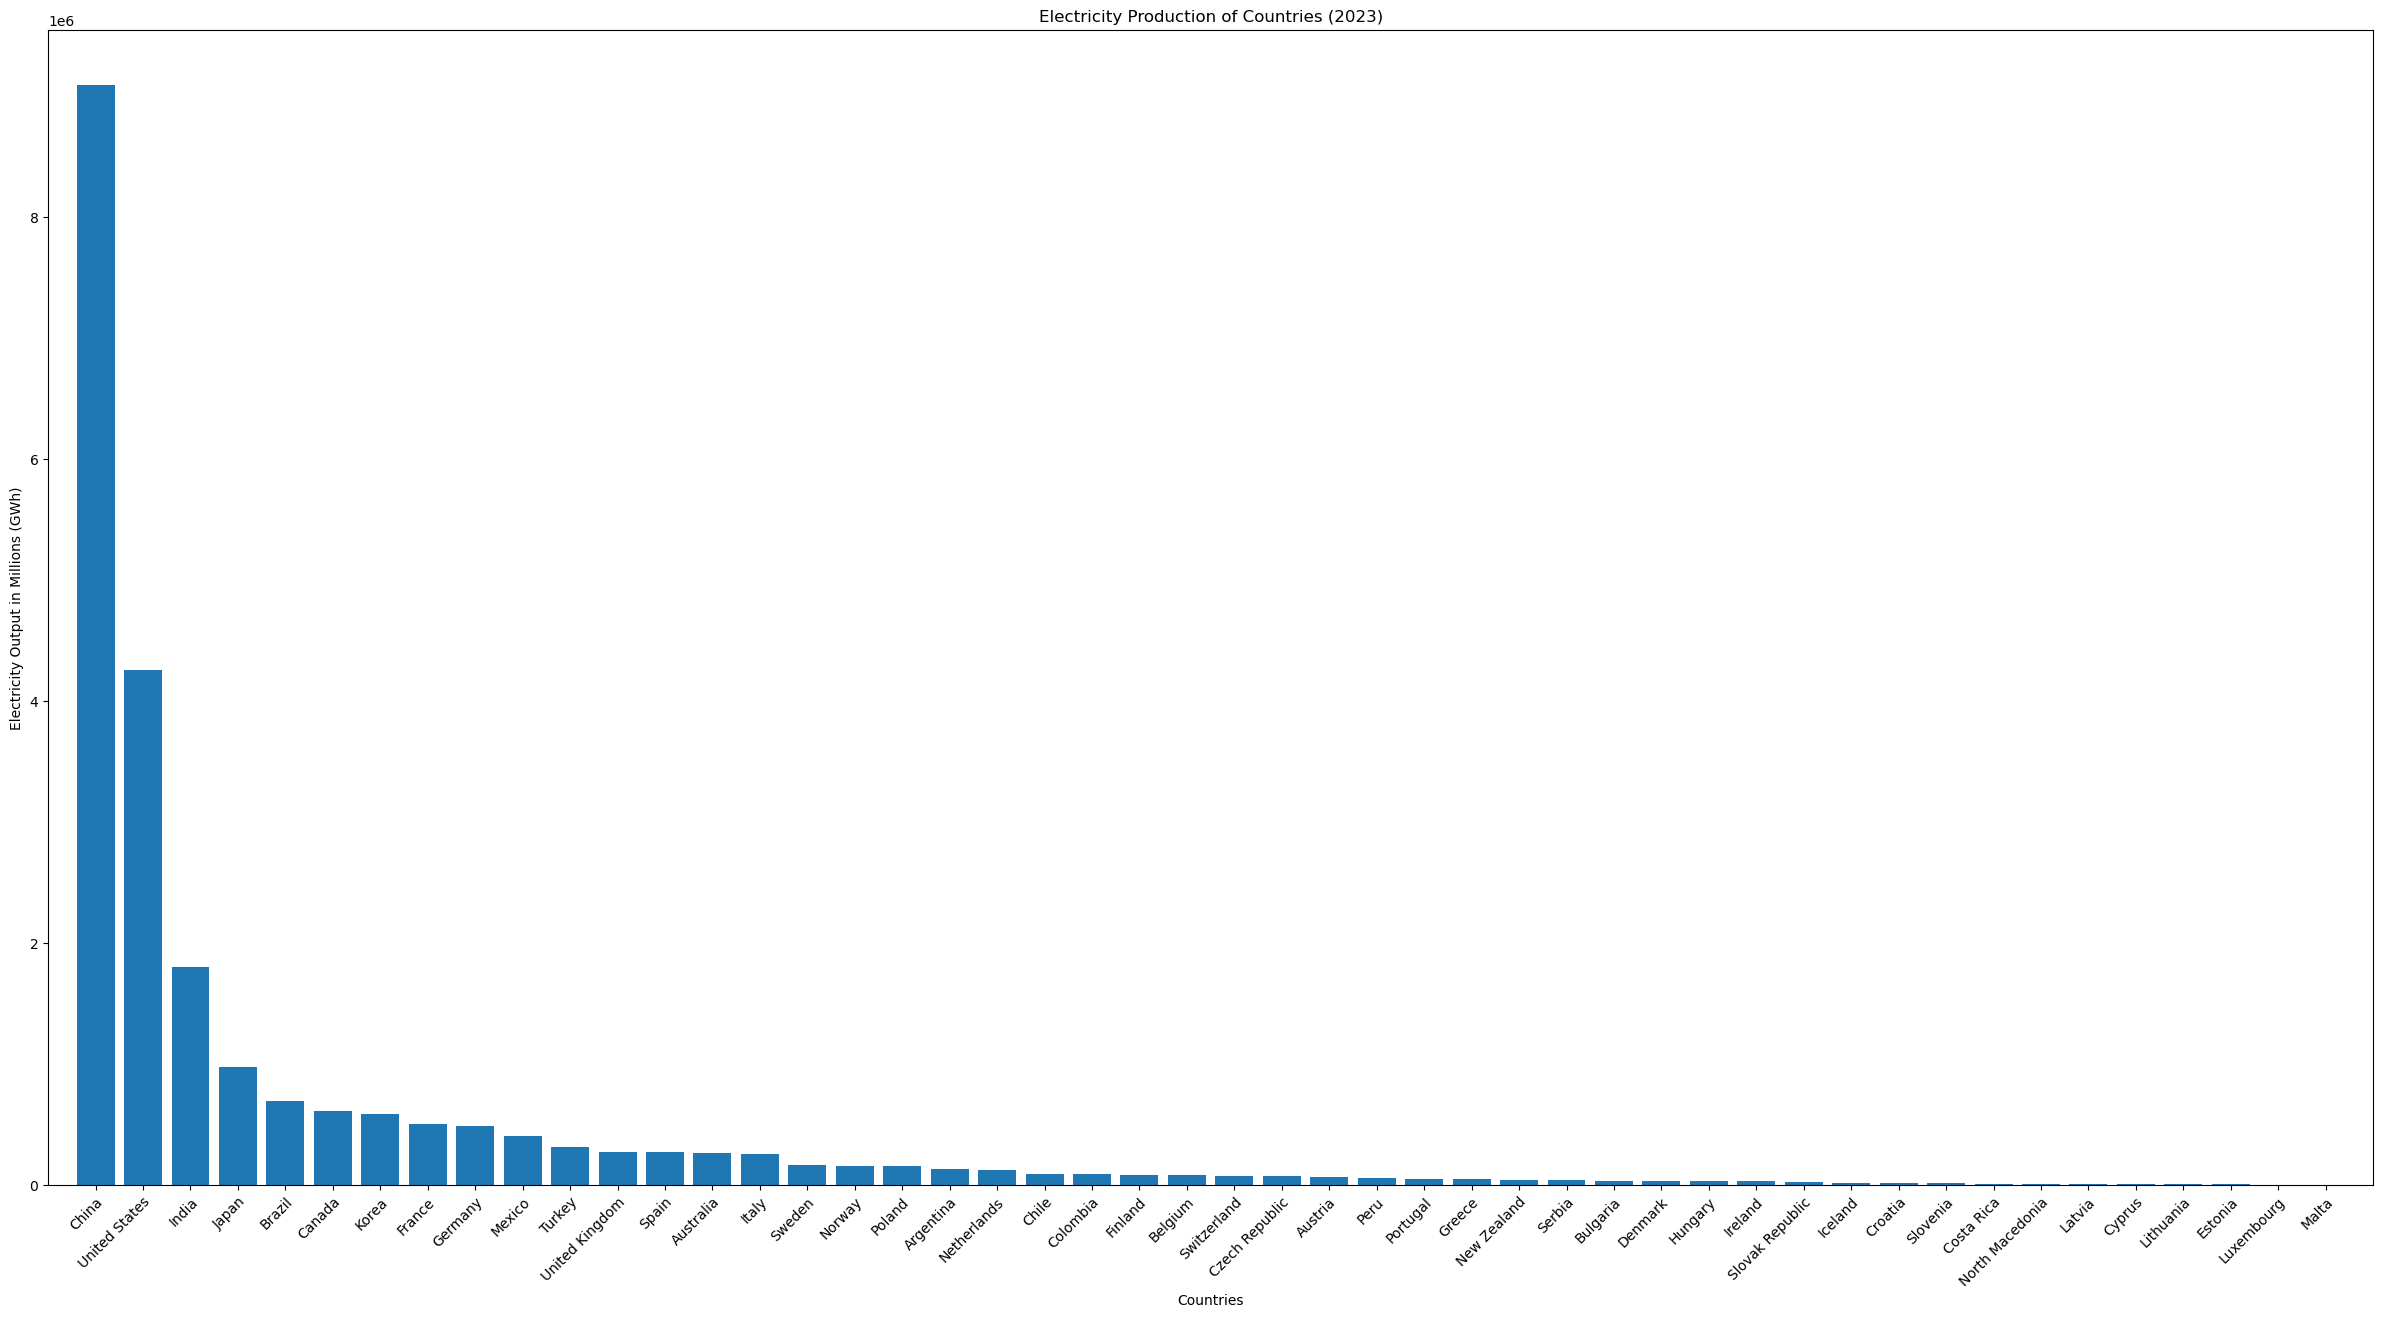

In [6]:
# Sort values
sorted_production_by_country_2023_df = production_by_country_2023_df.sort_values('value', ascending=False)

# Create a bar plot of all countries elerticity production in 2023
fig, ax = plt.subplots(figsize=(30,15))
ax.bar(sorted_production_by_country_2023_df['country_name'], sorted_production_by_country_2023_df['value'])

# Create labels
ax.set_xticks(ticks=sorted_production_by_country_2023_df['country_name'],labels=sorted_production_by_country_2023_df['country_name'],rotation_mode='anchor',ha='right', rotation=45)
ax.set_xlabel('Countries')
ax.set_ylabel('Electricity Output in Millions (GWh)')
ax.set_title('Electricity Production of Countries (2023)')
ax.set_xlim(-1, 48)

# Save image to output folder
fig.savefig('./output_data/electricity_2023_comparison.png')

# Display the plot
plt.show()

In [7]:
# Create lists for the latitudes and longitudes of each country
list_of_lats = []
list_of_lons = []

# Loop through Geoapify and extract the latitudes and longitudes of each country
for country in production_by_country_2023_df['country_name']:
    # Collect JSON request for a country in the dataframe
    query_url = f"https://api.geoapify.com/v1/geocode/search?country={country}&format=json&apiKey={geoapify_key}"
    json_response = requests.get(query_url).json()

    # Extract the lat and lons
    lat_response = json_response['results'][0]['lat']
    lon_response = json_response['results'][0]['lon']

    # Add them to each list
    list_of_lats.append(lat_response)
    list_of_lons.append(lon_response)

# Add the lats and lons to the dataframe
production_by_country_2023_df['lat'] = list_of_lats
production_by_country_2023_df['lon'] = list_of_lons

# Display dataframe
production_by_country_2023_df.head()

,country_name,value,lat,lon
8,Argentina,130607.86,-35.00,-64.97
22,Australia,261570.59,-24.78,134.75
36,Austria,67958.49,47.59,14.12
50,Belgium,78668.68,50.64,4.67
59,Brazil,690334.72,-10.33,-53.20


In [8]:
# Create list for the population of each country
population_list = []

# Loop through api ninja and extract the population of each country
for country in production_by_country_2023_df['country_name']:
    # Collect JSON request for a country in the dataframe
    ninja_url = f"https://api.api-ninjas.com/v1/country?name={country}&X-Api-Key={api_ninjas_key}"
    json_response = requests.get(ninja_url).json()

    # Extract the population
    pop_response = json_response[0]['population']*1000

    # Add them to each list
    population_list.append(pop_response)

# Add the lats and lons to the dataframe
production_by_country_2023_df['Population'] = population_list

# Display dataframe
production_by_country_2023_df.head()

,country_name,value,lat,lon,Population
8,Argentina,130607.86,-35.00,-64.97,45196000.00
22,Australia,261570.59,-24.78,134.75,25500000.00
36,Austria,67958.49,47.59,14.12,9006000.00
50,Belgium,78668.68,50.64,4.67,11590000.00
59,Brazil,690334.72,-10.33,-53.20,212559000.00


In [9]:
# Configure the map plot of each country with size based on electricity production in 2023
map_plot_1 = production_by_country_2023_df.hvplot.points('lon', 
                                          'lat', 
                                          geo=True,
                                          hover_cols=['country_name', 'value','lat', "lon", 'Population'],
                                          tiles='OSM',
                                          frame_width = 700,
                                          frame_height = 500,
                                          color ='country_name',
                                          size='value',
                                          alpha=.5,
                                          scale = .025)

# Display the map plot
map_plot_1 

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lon,lat]   (country_name,value,Population)

In [10]:
# Total counts grouped by country for 2023
total_electricity_2023 = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Electricity')&(original_df['Year']=='2023')].groupby('country_name')['value'].sum()
total_renewables_2023 = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Total Renewables (Hydro, Geo, Solar, Wind, Other)')&(original_df['Year']=='2023')].groupby('country_name')['value'].sum()
total_combustible_fuels_2023 = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Total Combustible Fuels')&(original_df['Year']=='2023')].groupby('country_name')['value'].sum()
combustible_renewables_2023 = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Combustible Renewables')&(original_df['Year']=='2023')].groupby('country_name')['value'].sum()
nonrenewable_combustible_fuels = total_combustible_fuels_2023-combustible_renewables_2023
nuclear_2023 = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Nuclear')&(original_df['Year']=='2023')].groupby('country_name')['value'].sum()
country_population = production_by_country_2023_df.groupby('country_name')['Population'].sum()

# Percents of electricity production using renewable, non-renewable combustible, and nuclear for 2023
percent_renewables_2023 = total_renewables_2023/total_electricity_2023*100
percent_nonrewable_2023 = nonrenewable_combustible_fuels/total_electricity_2023*100
percent_nuclear_2023 = nuclear_2023/total_electricity_2023*100

# The amount of electricity produced per person in MWh for 2023
electric_per_person = total_electricity_2023*1000/country_population

# Create a dataframe of summary statistics 
summary_statistics_2023 = pd.DataFrame({
    "Total Electricity Production (GWh)":total_electricity_2023,
    "Country Population": country_population,
    "Electricity Per Person (MWh)": electric_per_person,
    "% Renewable": percent_renewables_2023,
    "% Non-Renewable Combustible": percent_nonrewable_2023,
    "% Nuclear": percent_nuclear_2023,
})

# Replace NaN values with zeros
summary_statistics_2023 = summary_statistics_2023.fillna(0)

# Display the dataframe
summary_statistics_2023.index.name = None
summary_statistics_2023


,Total Electricity Production (GWh),Country Population,Electricity Per Person (MWh),% Renewable,% Non-Renewable Combustible,% Nuclear
Argentina,130607.86,45196000.00,2.89,31.75,61.36,6.90
Australia,261570.59,25500000.00,10.26,37.73,62.27,0.00
Austria,67958.49,9006000.00,7.55,84.53,15.45,0.00
Belgium,78668.68,11590000.00,6.79,34.52,25.34,39.70
Brazil,690334.72,212559000.00,3.25,90.05,7.97,1.98
Bulgaria,36645.54,6948000.00,5.27,26.00,32.06,41.87
Canada,614848.40,37742000.00,16.29,68.12,18.05,13.76
Chile,90521.96,19116000.00,4.74,65.69,34.31,0.00
China,9093177.33,1439324000.00,6.32,31.85,63.67,4.48
Colombia,86562.78,50883000.00,1.70,66.30,33.70,0.00


In [11]:
# Creates a dataframe from the summary statistics to show the bottom 10 based on renewable percentage
worst_percent_renewables = summary_statistics_2023.sort_values('% Renewable', ascending=True)

# Format numbers for better readability
worst_percent_renewables['Total Electricity Production (GWh)'] = worst_percent_renewables['Total Electricity Production (GWh)'].map('{:,.2f}'.format)
worst_percent_renewables['Country Population'] = worst_percent_renewables['Country Population'].map('{:,.0f}'.format)
worst_percent_renewables['% Renewable'] = worst_percent_renewables['% Renewable'].map('{:.0f}%'.format)
worst_percent_renewables['% Nuclear'] = worst_percent_renewables['% Nuclear'].map('{:.0f}%'.format)
worst_percent_renewables['% Non-Renewable Combustible'] = worst_percent_renewables['% Non-Renewable Combustible'].map('{:.0f}%'.format)

# Display the first 10 rows in the dataframe
worst_percent_renewables.head(10)

,Total Electricity Production (GWh),Country Population,Electricity Per Person (MWh),% Renewable,% Non-Renewable Combustible,% Nuclear
Korea,"589,428.61","25,779,000",22.86,9%,61%,29%
Malta,"2,231.05","442,000",5.05,11%,89%,0%
Mexico,"402,880.70","128,933,000",3.12,15%,81%,3%
Czech Republic,"70,516.83","10,709,000",6.58,16%,43%,41%
Cyprus,"5,124.54","1,207,000",4.25,21%,79%,0%
India,"1,802,220.14","1,380,004,000",1.31,22%,76%,3%
United States,"4,254,837.17","331,003,000",12.85,23%,59%,18%
Japan,"977,055.95","126,476,000",7.73,24%,66%,8%
Bulgaria,"36,645.54","6,948,000",5.27,26%,32%,42%
Hungary,"33,409.65","9,660,000",3.46,26%,28%,45%


In [12]:
# Creates a dataframe from the summary statistics to show the top 10 based on renewable percentage
best_percent_renewables = summary_statistics_2023.sort_values('% Renewable', ascending=False)

# Format numbers for better readability
best_percent_renewables['Total Electricity Production (GWh)'] = best_percent_renewables['Total Electricity Production (GWh)'].map('{:,.2f}'.format)
best_percent_renewables['Country Population'] = best_percent_renewables['Country Population'].map('{:,.0f}'.format)
best_percent_renewables['% Renewable'] = best_percent_renewables['% Renewable'].map('{:.0f}%'.format)
best_percent_renewables['% Nuclear'] = best_percent_renewables['% Nuclear'].map('{:.0f}%'.format)
best_percent_renewables['% Non-Renewable Combustible'] = best_percent_renewables['% Non-Renewable Combustible'].map('{:.0f}%'.format)

# Display the first 10 rows in the dataframe
best_percent_renewables.head(10)

,Total Electricity Production (GWh),Country Population,Electricity Per Person (MWh),% Renewable,% Non-Renewable Combustible,% Nuclear
Iceland,"19,843.28","341,000",58.19,100%,0%,0%
Costa Rica,"11,418.22","5,094,000",2.24,100%,0%,0%
Norway,"153,910.63","5,421,000",28.39,99%,1%,0%
Luxembourg,"2,280.12","626,000",3.64,94%,6%,0%
Denmark,"33,758.68","5,792,000",5.83,91%,9%,0%
Brazil,"690,334.72","212,559,000",3.25,90%,8%,2%
New Zealand,"43,036.99","4,822,000",8.93,88%,12%,0%
Austria,"67,958.49","9,006,000",7.55,85%,15%,0%
Latvia,"5,915.44","1,886,000",3.14,78%,22%,0%
Portugal,"49,002.14","10,197,000",4.81,75%,25%,0%


In [13]:
# Monthly averages grouped by country name for 2023
total_combustible_fuels_2023_average = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Total Combustible Fuels')&(original_df['Year']=='2023')].groupby('country_name')['value'].mean()
coal_peat_and_manufactured_gases_2023_average = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Coal, Peat and Manufactured Gases')&(original_df['Year']=='2023')].groupby('country_name')['value'].mean()
oil_and_petroleum_products_2023_average = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Oil and Petroleum Products')&(original_df['Year']=='2023')].groupby('country_name')['value'].mean()
natural_gas_2023_average = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Natural Gas')&(original_df['Year']=='2023')].groupby('country_name')['value'].mean()
combustible_renewables_2023_average = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Combustible Renewables')&(original_df['Year']=='2023')].groupby('country_name')['value'].mean()
hydro_2023_average = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Hydro')&(original_df['Year']=='2023')].groupby('country_name')['value'].mean()
wind_2023_average = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Wind')&(original_df['Year']=='2023')].groupby('country_name')['value'].mean()
solar_2023_average = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Solar')&(original_df['Year']=='2023')].groupby('country_name')['value'].mean()
total_renewables_2023_average = original_df[(original_df['parameter']=='Net Electricity Production')&(original_df['product']=='Total Renewables (Hydro, Geo, Solar, Wind, Other)')&(original_df['Year']=='2023')].groupby('country_name')['value'].mean()

# Create a dataframe of averages 
monthly_averages_2023 = pd.DataFrame({
    "Total Combustible Fuels (Monthly AVG)":total_combustible_fuels_2023_average,
    "Coal, Peat and Manufactured Gases (Monthly AVG)": coal_peat_and_manufactured_gases_2023_average,
    "Oil and Petroleum Products (Monthly AVG)": oil_and_petroleum_products_2023_average,
    "Natural Gas (Monthly AVG)":natural_gas_2023_average,
    "Combustible Renewables (Monthly AVG)": combustible_renewables_2023_average,
    "Hydro (Monthly AVG)": hydro_2023_average,
    "Wind (Monthly AVG)": wind_2023_average,
    "Solar (Monthly AVG)": solar_2023_average,
    "Total Renewables (Monthly AVG)": total_renewables_2023_average
})

# replace NaN values with zeros
monthly_averages_2023 = monthly_averages_2023.fillna(0)

# Display the dataframe
monthly_averages_2023.index.name = None
monthly_averages_2023

,Total Combustible Fuels (Monthly AVG),"Coal, Peat and Manufactured Gases (Monthly AVG)",Oil and Petroleum Products (Monthly AVG),Natural Gas (Monthly AVG),Combustible Renewables (Monthly AVG),Hydro (Monthly AVG),Wind (Monthly AVG),Solar (Monthly AVG),Total Renewables (Monthly AVG)
Argentina,6858.20,95.55,1078.41,5504.02,180.22,1810.41,1194.47,270.02,3455.13
Australia,13824.25,9812.90,321.99,3438.42,250.94,1323.84,2680.13,3969.32,8224.24
Austria,1239.09,156.69,65.79,591.67,364.21,3555.18,644.55,223.14,4787.08
Belgium,1913.66,148.91,6.82,1424.41,252.43,135.15,1252.96,622.80,2263.34
Brazil,9306.67,1231.45,593.90,2621.90,4719.49,35158.41,7868.16,4055.03,51801.08
Bulgaria,1113.45,822.02,18.11,138.83,134.50,254.17,131.93,273.49,794.08
Canada,10056.31,2743.57,340.96,6154.80,806.63,30106.40,3142.94,849.44,34905.41
Chile,3021.69,1179.87,40.48,1367.78,433.56,2274.36,859.03,1351.59,4955.36
China,496308.54,458266.10,964.90,22667.67,13847.41,103522.67,80369.70,43614.41,241364.65
Colombia,2612.50,827.79,268.30,1334.99,181.41,4550.65,4.71,46.49,4782.48


# How does population impact electricity production?

# How do the ratios of fossil fuel vs renewables for electricity compare in countries?

# What do we predict the future fossil fuel to renewable ratio will look like for the U.S.?